In [65]:
input_spe = (32, 32, 1)
latent_dim = 14  # how many features we are looking for

PATH = 'D:/magist/semestr 2/UczNienadwz/UNN/1_sign_per_class_no_distortions_whole_book/1_sign_per_class_no_distortions_whole_book/dataset_1_sign_per_class_no_distortions_whole_book.npy'

# imports

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow import keras
from tensorflow.keras import layers

# dataset

In [67]:
def delete_space(dataset):
    # search for space
    # plt.imshow(dataset[0])
    # plt.show()

    # delete it
    space = dataset[0]
    lst = []
    for i in dataset:
        if np.array_equal(space, i):
            pass
        else:
            lst.append(i)

    better_dataset = np.asarray(lst)

    return better_dataset


def read_dataset_no_spaces(path):
    images = np.load(path)
    print("images", images.shape)

    lacina, hiragana = images[:, 0, :, :], images[:, 1, :, :]
    print("lacina", lacina.shape)

    lacina, hiragana = delete_space(lacina), delete_space(hiragana)
    print("lacina", lacina.shape, "--no spaces")

    lacina, hiragana = np.expand_dims(lacina, -1).astype("float32") / 255, np.expand_dims(hiragana, -1).astype("float32") / 255
    print("lacina", lacina.shape, "--good shape")

    return lacina, hiragana

# Encoder + Decoder = VAE

In [68]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mean, log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape = tf.shape(mean), mean = 0., stddev = 1.)
        return mean + tf.exp(log_var / 2) * epsilon


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name = "total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name = "reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name = "kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker, ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(), }


def create_vae():
    #encoder
    encoder_inputs = keras.Input(shape = input_spe)
    x = Conv2D(32, 3, activation = "relu", strides = 2, padding = "same")(encoder_inputs)
    x = Conv2D(64, 3, activation = "relu", strides = 2, padding = "same")(x)
    x = Conv2D(64, 3, activation = "relu", strides = 2, padding = "same")(x)
    x = Flatten()(x)
    x = Dense(300, activation = "relu")(x)
    z_mean = Dense(latent_dim, name = "z_mean")(x)
    z_log_var = Dense(latent_dim, name = "z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name = "encoder")
    # encoder.summary()
    # plot_model(encoder, show_shapes = True, dpi = 80)

    #decoder
    latent_inputs = keras.Input(shape = (latent_dim,))
    x = Dense(4 * 4 * 64, activation = "relu")(latent_inputs)
    x = Reshape((4, 4, 64))(x)
    x = Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same")(x)
    x = Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same")(x)
    x = Conv2DTranspose(32, 3, activation = "relu", strides = 2, padding = "same")(x)
    decoder_outputs = Conv2DTranspose(1, 3, activation = "sigmoid", padding = "same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name = "decoder")
    # decoder.summary()
    # plot_model(decoder, show_shapes = True, dpi = 80)

    # autoencoder
    vae = VAE(encoder, decoder)
    vae.compile(optimizer = keras.optimizers.Adam())

    return vae


def show_plots(history):
    plt.figure(figsize = (15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['reconstruction_loss'])
    plt.title('reconstruction_loss')
    plt.ylabel('reconstruction_loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 3, 3)
    plt.plot(history.history['kl_loss'])
    plt.title('kl_loss')
    plt.ylabel('kl_loss')
    plt.xlabel('Epoch')


def save_autoencoder(autoencoder, encoder_file_name, decoder_file_name):
    autoencoder.encoder.save(encoder_file_name)
    autoencoder.decoder.save(decoder_file_name)
    print('saved')

## dataset

In [69]:
lacina, hiragana = read_dataset_no_spaces(PATH)

images (310080, 2, 32, 32)
lacina (310080, 32, 32)
lacina (103886, 32, 32) --no spaces
lacina (103886, 32, 32, 1) --good shape


In [71]:
epochs = 4
batch_size = 521

### lacina data

In [72]:
autoencoder = create_vae()

Epoch 1/4
200/200 [==============================] - 58s 280ms/step - loss: 370.9766 - reconstruction_loss: 246.7636 - kl_loss: 10.8780
Epoch 2/4
200/200 [==============================] - 57s 287ms/step - loss: 60.5108 - reconstruction_loss: 21.6440 - kl_loss: 19.5142
Epoch 3/4
200/200 [==============================] - 57s 285ms/step - loss: 20.1547 - reconstruction_loss: 4.0309 - kl_loss: 14.4896
Epoch 4/4
200/200 [==============================] - 57s 285ms/step - loss: 15.3698 - reconstruction_loss: 2.4621 - kl_loss: 12.4420


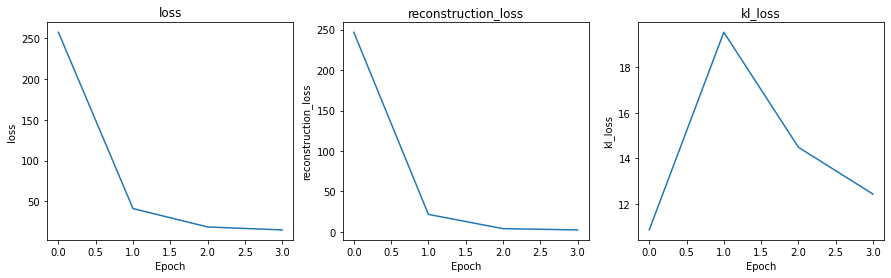

In [73]:
history = autoencoder.fit(lacina, epochs = epochs, batch_size = batch_size)
show_plots(history)

In [74]:
save_autoencoder(autoencoder, 'vaeEncoder_lacina', 'vaeDecoder_lacina')

INFO:tensorflow:Assets written to: vaeEncoder_lacina\assets


INFO:tensorflow:Assets written to: vaeEncoder_lacina\assets


INFO:tensorflow:Assets written to: vaeDecoder_lacina\assets


INFO:tensorflow:Assets written to: vaeDecoder_lacina\assets


saved


### hiragana data

In [61]:
autoencoder = create_vae()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 16, 16, 32)   320         ['input_22[0][0]']               
                                                                                                  
 conv2d_34 (Conv2D)             (None, 8, 8, 64)     18496       ['conv2d_33[0][0]']              
                                                                                                  
 conv2d_35 (Conv2D)             (None, 4, 4, 64)     36928       ['conv2d_34[0][0]']              
                                                                                            

Epoch 1/4
200/200 [==============================] - 60s 293ms/step - loss: 410.1083 - reconstruction_loss: 269.1082 - kl_loss: 13.9921
Epoch 2/4
200/200 [==============================] - 59s 297ms/step - loss: 57.8114 - reconstruction_loss: 21.2123 - kl_loss: 22.2271
Epoch 3/4
200/200 [==============================] - 58s 289ms/step - loss: 24.4828 - reconstruction_loss: 5.4432 - kl_loss: 17.3652
Epoch 4/4
200/200 [==============================] - 58s 292ms/step - loss: 19.2063 - reconstruction_loss: 3.2650 - kl_loss: 15.1405


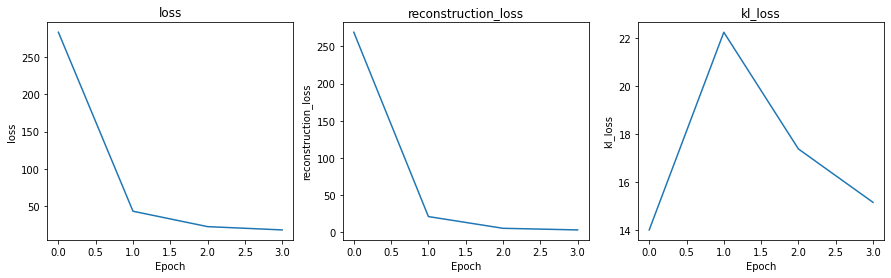

In [62]:
history = autoencoder.fit(hiragana, epochs = epochs, batch_size = batch_size)
show_plots(history)

In [63]:
save_autoencoder(autoencoder, 'vaeEncoder_hiragana', 'vaeDecoder_hiragana')

INFO:tensorflow:Assets written to: vaeEncoder_hiragana\assets


INFO:tensorflow:Assets written to: vaeEncoder_hiragana\assets


INFO:tensorflow:Assets written to: vaeDecoder_hiragana\assets


INFO:tensorflow:Assets written to: vaeDecoder_hiragana\assets


saved
